In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [9]:
# Mapping of RGB values to class labels
RGB_TO_CLASS = {
    (0, 255, 255): 0,  # Urban Land
    (255, 255, 0): 1,  # Agriculture Land
    (255, 0, 255): 2,  # Rangeland
    (0, 255, 0): 3,    # Forest Land
    (0, 0, 255): 4,    # Water
    (255, 255, 255): 5,  # Barren Land
    (0, 0, 0): 6       # Unknown (if present)
}

# Data loading function
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('_sat.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_filename = filename.replace('_sat.jpg', '_mask.png')
            mask_path = os.path.join(mask_dir, mask_filename)

            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)

            # Load RGB mask
            mask = cv2.imread(mask_path)
            if mask is None:
                continue
            mask = cv2.resize(mask, img_size)

            # Map RGB values to class labels
            mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
            for i in range(mask.shape[0]):
                for j in range(mask.shape[1]):
                    pixel = tuple(mask[i, j])  # Get the (R, G, B) tuple
                    if pixel in RGB_TO_CLASS:
                        mask_class[i, j] = RGB_TO_CLASS[pixel]
                    else:
                        mask_class[i, j] = 6  # Assign class '6' for unknown pixels

            # Append to lists
            images.append(img)
            masks.append(mask_class)

    return np.array(images), np.array(masks)

In [10]:
# Load training data
X_train, y_train = load_data("/kaggle/input/deepglobe-land-cover-classification-dataset/train", "/kaggle/input/deepglobe-land-cover-classification-dataset/train")

# Normalize the images
X_train = X_train.astype(np.float32) / 255.0





NameError: name 'to_categorical' is not defined

In [11]:
from tensorflow.keras.utils import to_categorical 
# One-hot encode the masks (7 classes, including 'unknown')
y_train = to_categorical(y_train, num_classes=7)

# Check the shapes
print(f"X_train shape: {X_train.shape}")  # (num_samples, 256, 256, 3)
print(f"y_train shape: {y_train.shape}")  # (num_samples, 256, 256, 7)

X_train shape: (803, 256, 256, 3)
y_train shape: (803, 256, 256, 7)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10


I0000 00:00:1732484813.897885      80 service.cc:145] XLA service 0x7e715410b7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732484813.897945      80 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732484813.897950      80 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/51 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.3039 - loss: 1.8754 

I0000 00:00:1732484830.773107      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.5514 - loss: 1.5186
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5891 - loss: 1.2767 
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6120 - loss: 1.1939 
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6253 - loss: 1.1533
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6565 - loss: 1.0819
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6643 - loss: 1.0863
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6866 - loss: 0.9980
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7020 - loss: 0.9270
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6860 - loss: 0.9741
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7275 - loss: 0.8631


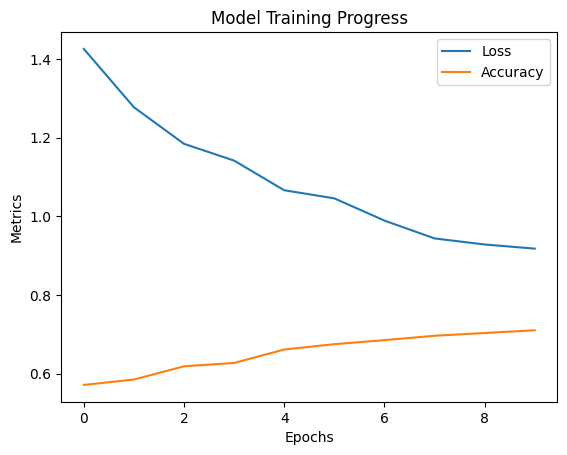

In [12]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define a simple CNN model for multi-class segmentation
def build_model(input_shape=(256, 256, 3), num_classes=7):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(num_classes, (3, 3), activation='softmax', padding='same')  # Use softmax for multi-class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
model = build_model()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16)

# Visualize training progress
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


In [17]:
# Predict on the test set
# Load test data (no masks available)
def load_test_data(image_dir, img_size=(256, 256)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('_sat.jpg'):
            # Image file path
            img_path = os.path.join(image_dir, filename)
            
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            
            images.append(img)
    
    return np.array(images)

# Load test data
X_test = load_test_data("/kaggle/input/deepglobe-land-cover-classification-dataset/test")
predictions = model.predict(X_test)



6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


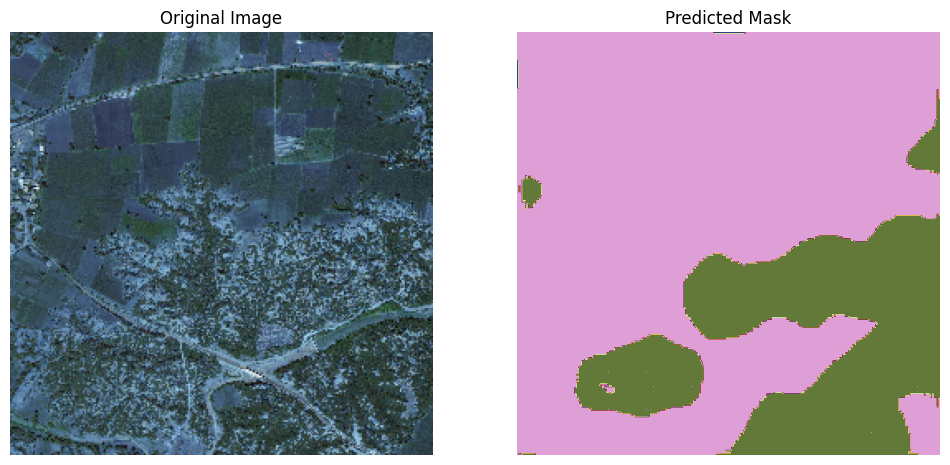

In [18]:
# Visualize the first test image and its corresponding predicted mask
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(X_test[50])  # Display the original image
plt.title("Original Image")
plt.axis("off")

# Show predicted mask
plt.subplot(1, 2, 2)
# Convert predictions to class labels (for visualization purposes)
predicted_classes = np.argmax(predictions[50], axis=-1)  # Get the class with highest probability per pixel
plt.imshow(predicted_classes, cmap='tab20b')  # Use a colormap for better visualization
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


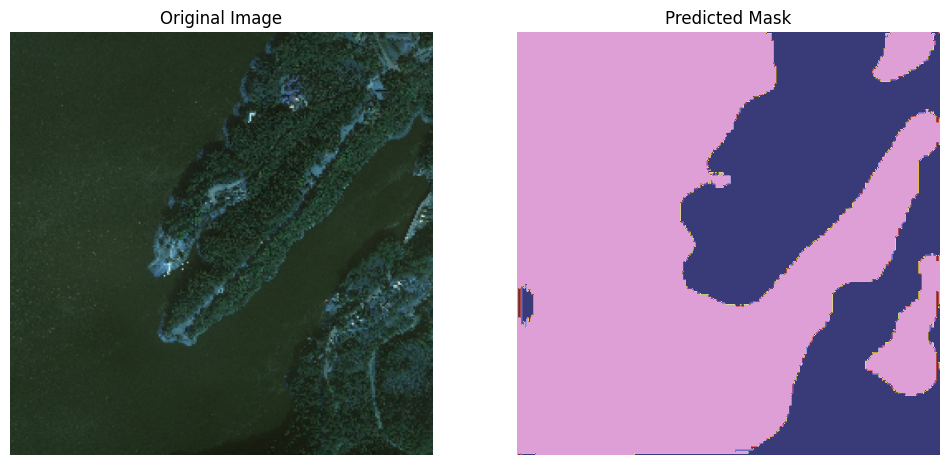

In [20]:
# Visualize the first test image and its corresponding predicted mask
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(X_test[10])  # Display the original image
plt.title("Original Image")
plt.axis("off")

# Show predicted mask
plt.subplot(1, 2, 2)
# Convert predictions to class labels (for visualization purposes)
predicted_classes = np.argmax(predictions[10], axis=-1)  # Get the class with highest probability per pixel
plt.imshow(predicted_classes, cmap='tab20b')  # Use a colormap for better visualization
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
